In [1]:
# 재설정 후 필요한 라이브러리와 초기 설정을 다시 가져오기
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
# 두 점 사이의 거리를 계산하는 함수
def distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))


In [3]:
# 미분 방정식 (운동 방정식)
def three_body_equations(t, y, masses):
    n = len(masses)
    positions = y[:3*n].reshape((n, 3))
    velocities = y[3*n:].reshape((n, 3))
    derivatives = np.zeros_like(y)

    # 위치의 도함수는 속도
    derivatives[:3*n] = velocities.reshape(3*n)

    # 속도(가속도)의 도함수 계산
    for i in range(n):
        acceleration = np.zeros(3)
        for j in range(n):
            if i != j:
                r = distance(positions[i], positions[j])
                acceleration += masses[j] * (positions[j] - positions[i]) / r**3
        derivatives[3*n + 3*i:3*n + 3*(i+1)] = acceleration
    
    return derivatives

In [4]:
# 초기 조건과 질량 설정
# 4/3 파이 * 반지름의 세제곱을 사용하여 천체의 부피를 계산하고, 이를 질량으로 사용
M1 = 4/3*np.pi*4**3
M2 = 4/3*np.pi*2**3
M3 = 4/3*np.pi*1**3
masses = [M1, M2, M3]  # 세 천체의 질량
initial_positions = np.array([[1, 0, 0], [-1, 0, 0], [0, 1, 0]])  # 초기 위치
initial_velocities = np.array([[0, 1, 0], [0, -1, 0], [0, 0, -1]])  # 초기 속도
initial_conditions = np.concatenate([initial_positions.flatten(), initial_velocities.flatten()])

In [5]:
# 시뮬레이션 시간 범위와 해결책 계산
t_span = (0, 1000)
t_eval = np.linspace(*t_span, 100)
solution = solve_ivp(three_body_equations, t_span, initial_conditions, args=(masses,), t_eval=t_eval, rtol=1e-5)

Text(0.5, 0, 'Z')

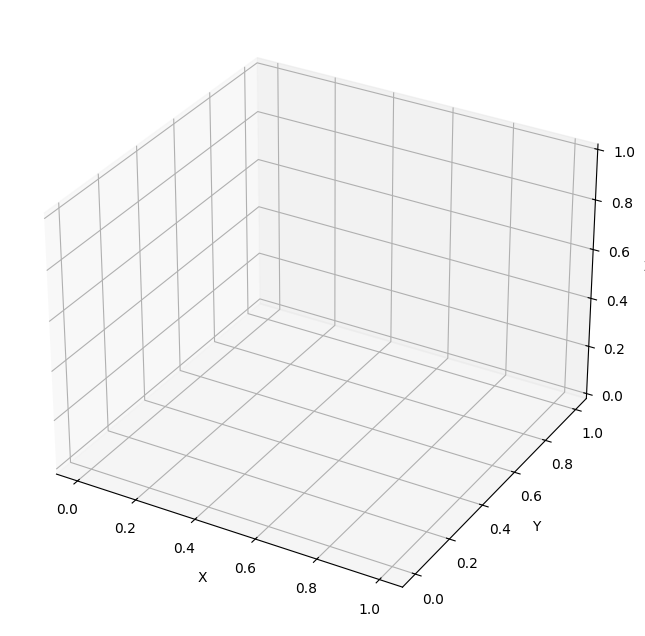

In [6]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
lines = [ax.plot([], [], [], lw=2)[0] for _ in range(len(masses))]

# 축 레이블 설정
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [7]:
# 애니메이션을 위한 초기화 함수
def init():
    for line in lines:
        line.set_data([], [])
        line.set_3d_properties([])
    return lines

def update_permanent_trails(frame):
    # 모든 시점의 천체 위치 데이터를 그대로 누적하여 그림
    for i, line in enumerate(lines):
        line.set_data(solution.y[i*3, :frame+1], solution.y[i*3+1, :frame+1])
        line.set_3d_properties(solution.y[i*3+2, :frame+1])
    
    # 축 범위를 동적으로 조정하여 천체가 항상 보이도록 함
    current_positions = np.vstack([solution.y[i*3:i*3+3, :frame+1] for i in range(len(masses))])
    min_pos = np.min(current_positions, axis=1) - 1.5
    max_pos = np.max(current_positions, axis=1) + 1.5
    ax.set_xlim(min_pos[0], max_pos[0])
    ax.set_ylim(min_pos[1], max_pos[1])
    ax.set_zlim(min_pos[2], max_pos[2])

    return lines

# 축의 범위를 더 넓게 설정하여 모든 천체들이 잘 보이도록 축 범위를 초기에 설정하는 함수
def set_wide_axis_ranges():
    # 모든 시점의 천체 위치 데이터를 기반으로 축 범위를 결정
    all_positions = np.vstack([solution.y[i*3:i*3+3] for i in range(len(masses))])
    min_pos = np.min(all_positions, axis=1) - 5  # 여백을 추가하여 넓은 범위 설정
    max_pos = np.max(all_positions, axis=1) + 5
    
    # 축 범위 설정
    ax.set_xlim(min_pos[0], max_pos[0])
    ax.set_ylim(min_pos[1], max_pos[1])
    ax.set_zlim(min_pos[2], max_pos[2])



In [8]:
# 애니메이션 생성 및 실행 (모든 궤적 영구적으로 남김)
ani_permanent_trails_wide_range = FuncAnimation(fig, update_permanent_trails, frames=np.arange(1, len(t_eval)),
                                                init_func=init, blit=True, repeat=False, interval=20)

plt.show()
